In [1]:
import pyfor

# The Basics

In [2]:
#reading las file
tile = pyfor.cloud.Cloud("./data/test.las")

In [3]:
print(tile)

Minimum (x y z): [405000.01, 3276300.01, 36.29]
Maximum (x y z): [405199.99, 3276499.99, 61.12]
Number of Points: 217222
File Size: 6082545
LAS Specification: 1.3



In [4]:
#print data columns
print(tile.data.points.columns.tolist())

['x', 'y', 'z', 'intensity', 'return_num', 'classification', 'flag_byte', 'scan_angle_rank', 'user_data', 'pt_src_id']


In [5]:
print(tile.data.points.head())

           x           y      z  intensity  return_num  classification  \
0  405120.99  3276300.01  53.05          0           1               5   
1  405120.29  3276300.04  52.36          0           1               5   
2  405119.94  3276300.09  53.00          0           1               5   
3  405117.94  3276300.04  47.46          0           1               5   
4  405118.21  3276300.12  50.32          0           1               5   

   flag_byte  scan_angle_rank  user_data  pt_src_id  
0         81               15        149         11  
1         73               15        143         11  
2         73               15        150         11  
3         73               15         93         11  
4         73               15        121         11  


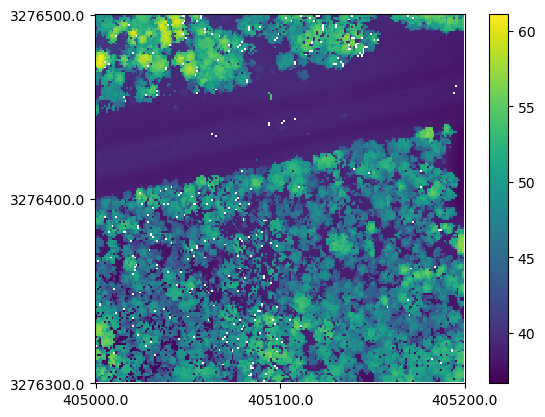

In [6]:
#plotting in 2d (raster)
tile.plot()

In [7]:
#plot point cloud 
tile.plot3d()

In [11]:
#filtering raw points
tile.data.points = tile.data.points[tile.data.points["x"] > 360]

In [12]:
#writing points
tile.write("new_tile.las")

# Canopy height model

In [5]:
#Basci canomy height model
tile.normalize(0.5)
chm = tile.chm(0.5)

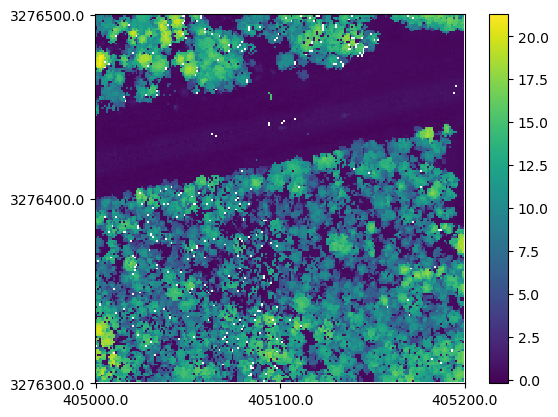

In [9]:
tile.plot()

In [6]:
#improved chm
better_chm = tile.chm(0.5, interp_method = "nearest", pit_filter = "median")

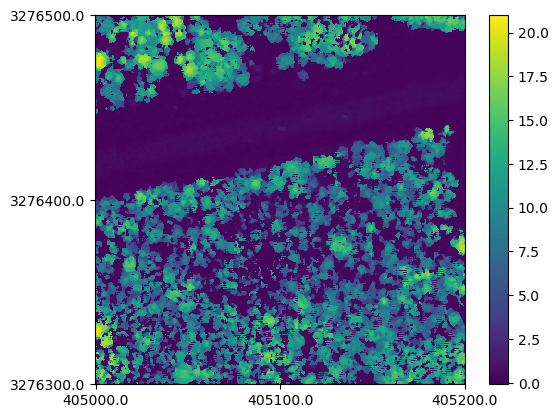

In [11]:
better_chm.plot()

In [7]:
print(better_chm)

In [8]:
print(better_chm.array.shape)

(400, 400)


In [9]:
import numpy as np

print(np.min(better_chm.array))
print(np.max(better_chm.array))

-0.09000000000000341
21.019999999999996


In [11]:
#spatial reference
tile.crs = "EPSG:26910" 
#save tif file (chm)
better_chm.write('my_chm.tif')

# DTM model

In [12]:
from pyfor.ground_filter import Zhang2003

In [13]:
zhang_filter = Zhang2003(0.5)

In [14]:
#computing dtm
dtm = zhang_filter.bem(tile)

In [15]:
print(dtm)

In [16]:
print(dtm.array.shape)

(400, 400)


In [17]:
print(np.min(dtm.array))
print(np.max(dtm.array))

-0.5999999999999943
0.10999999999999943


In [18]:
#saving tif file
dtm.write('my_dtm.tif')

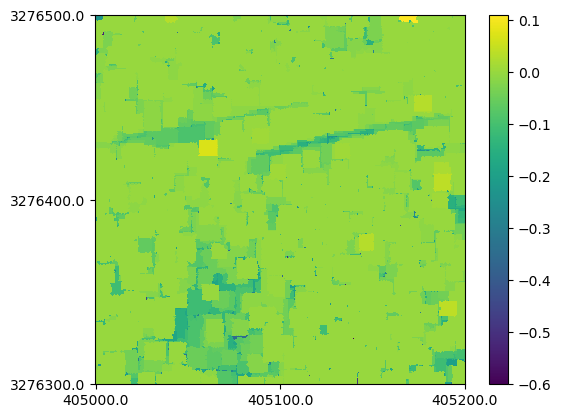

In [28]:
dtm.plot()

In [19]:
#computing dsm as an array
dsm = better_chm.array + dtm.array

In [23]:
print(dsm)

[[-0.23  6.51  6.73 ...  0.37  0.56  0.  ]
 [ 4.46  6.73  6.98 ...  0.56  6.59  0.56]
 [ 3.97  7.54  7.54 ...  7.24 10.09  6.59]
 ...
 [ 0.19  0.48  0.78 ...  8.24  8.24  0.82]
 [ 0.56  0.63  5.9  ... 13.02 10.32  0.82]
 [ 0.    0.63  5.9  ... 10.32 10.32  0.  ]]


In [32]:
#save dsm in csv format
np.savetxt('mydsm_array.csv', dsm, delimiter=',')

# Coverting array to raster and save tif file (dsm)

In [21]:
#https://www.youtube.com/watch?v=p_BsFdV_LUk&list=FL6wfe51KkhxfeQwuyURYnQQ&index=3&ab_channel=MakingSenseRemotely

from osgeo import gdal

import numpy as np

In [22]:
ds = gdal.Open("my_chm.tif")    #call CHM to use its transform and projection
gt = ds.GetGeoTransform()
proj = ds.GetProjection()
band = ds.GetRasterBand(1)
array = band.ReadAsArray()

In [25]:
dsm = np.loadtxt('mydsm_array.csv', delimiter=',')

In [26]:
print(dsm)

[[-0.23  6.51  6.73 ...  0.37  0.56  0.  ]
 [ 4.46  6.73  6.98 ...  0.56  6.59  0.56]
 [ 3.97  7.54  7.54 ...  7.24 10.09  6.59]
 ...
 [ 0.19  0.48  0.78 ...  8.24  8.24  0.82]
 [ 0.56  0.63  5.9  ... 13.02 10.32  0.82]
 [ 0.    0.63  5.9  ... 10.32 10.32  0.  ]]


In [27]:
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("my_dsm.tif", xsize = dsm.shape[1], ysize = dsm.shape[0], bands=1, eType=gdal.GDT_Int16)
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(dsm)
outband.SetNoDataValue(np.nan)
outband.FlushCache()

outband = None
outds = None